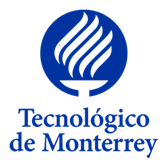

## Proyecto Integrador
## Smart Travel Assistant: Optimizando la Experiencia de Viaje con IA
## Avance 4

### Equipo 37
##### A00759664 - Joel Orlando Hernández Ramos
##### A01793486 - Juan Carlos Alvarado Carricarte
##### A00260430 - Juan Carlos Romo Cárdenas


## **Descripción del Proyecto**

Este proyecto se propone desarrollar un asistente de inteligencia artificial integrado en una plataforma de traveltech, que facilita la elección personalizada de hoteles y destinos para los usuarios. Utilizando la función "knowledge base" de Amazon Bedrock, el sistema integrará una extensa base de datos con información detallada sobre más de 2 millones de hoteles. Para este efecto  

El objetivo principal de este proyecto es transformar la experiencia de planificación de viajes, haciendo que sea más intuitiva, personalizada y respaldada por datos. Las metas específicas incluyen mejorar la satisfacción del cliente mediante recomendaciones precisas y personalizadas, reducir el tiempo necesario para planificar un viaje y aumentar la eficiencia del proceso de selección de destinos y hoteles.

El asistente empleará modelos avanzados de sistemas de recomendación, potenciados por un modelo de lenguaje de aprendizaje profundo (LLM), para sugerir itinerarios personalizados y ofrecer asistencia general en la planificación de viajes. Las recomendaciones incluirán referencias detalladas a los hoteles disponibles en nuestra base de datos, asegurando que los usuarios reciban opciones que no solo se ajustan a sus preferencias personales, sino que también maximizan la calidad y la relevancia de la información proporcionada.

## **Configuración la Base de Conocimiento y el Modelo Fundacional**

<img src="./Proyecto Integrador - RAG con Bedrock-Smart Travel Assistant KB v2.00 LangChain.drawio.png" alt="RAG Bedrock KB V1.00" />

Para crear el modelo de referencia para este proyecto se creo una base de datos de conocimientos en **AWS Bedrock**. El proceso es el siguiente:
1. Crear la base de conocimientos, o **Knowledge Base**. Para este proyecto la base de conocimiento se llama *Volindo-hotels* y se usa una base de datos de vectores de **Pinecone**
> * La fuente de conocimiento incluye más de 160 mil pares de archivos de texto y JSON con los datos de más de 145,000 hoteles. Cada par de archivos representa un hotel.
2. Cargar los datos en un Bucket de S3, llamado *hotel-clean-data*
3. Asociar el Bucket de S3 como una fuente de información para la base de conocimiento
4. Sincronizar (cargar) los datos de la fuente de información

Una vez cargado la base de conocimiento se puede probar usando la consola de AWS Bedrock o a través de APIs, tal y como se hará a continuación.

## **Probando la Base de Conocimiento y el Modelo Fundacional**

### **Preparando el Ambiente de Ejecución**

Es necesario importar las librerías necesarias para iniciar una sesión de AWS y para registrar una bitácora de ejecución.

In [97]:
# Importando librerias requeridas
import time
import re
import json
import uuid
import io
import logging
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import boto3

import chromadb
from chromadb.config import DEFAULT_TENANT, DEFAULT_DATABASE, Settings
from chromadb.utils.embedding_functions import DefaultEmbeddingFunction

from langchain_community.llms import LlamaCpp
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnablePick
from langchain import hub

from langchain_chroma import Chroma

### **Evaluando la Base de Conocimiento y el Modelo Fundacional**

AWS Bedrock provee tres tipos de mecanismos para evaluar el desempeño de los modelos fundacionales:
* Evaluación automatizada
* Evaluación por un equipo de humanos
* Evaluación por un servicio de evaluación de AWS

La evaluación automatizada permite hacer evaluaciones de la precisión del modelo, la toxicidad de las respuestas y la robustes de las respuestas. Desafortunadamente AWS solo ofrece este servicio para solo uno de los modelos de Amazon y no cubre la evaluación de la base de conocimiento y de las respuestas generadas en combinación con el modelo fundacional de Titan Text Premier.

Durante estas pruebas se hará una evaluación cualitativa de las repuestas. Para este efecto cada participante del equipo proveerá una calificación de la respuesta indicando si la respuesta es o no correcta, si es precisa o imprecisa y si está o no basada en los hechos de referencia. La calificación se evalúa en una escala del 1 al 5 como sigue  (Grech, 2024):

1. La respuesta es completamente incorrecta, imprecisa y/o no basada en los hechos
2. La respuesta es en su mayoría incorrecta, imprecisa y/o no basada en los hechos
3. La respuesta es de alguna manera correcta, precisa y/o basada en los hechos
4. La respuesta es en su mayoría correcta, precisa y/o basada en los hechos
5. La respuesta es completamente correcta, precisa y/o basada en los hechos


### **Creando Agente para Recuperar Informacion de Contexto**

In [98]:
# Creando sesion para AWS Bedrock. Credenciales y configuracion se obtienen de ~/.aws
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

db_client = chromadb.PersistentClient(
    path="../chroma/4p",
    tenant=DEFAULT_TENANT,
    database=DEFAULT_DATABASE,
)

vector_store = Chroma(
    'volindo',
    client=db_client,
    embedding_function=embeddings,
    collection_metadata={"hnsw:space": "cosine"}
)



/Users/jcromo/Miniconda3/envs/proyecto/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### **Creando Agente para Questionar el Modelo Fundacional**

In [99]:
model_kwargs_premier = {'temperature': 0, 'topP': 0.7, 'maxTokenCount': 3000}
n_gpu_layers = 1  # Metal set to 1 is enough.
n_batch = 512  # Should be between 1 and n_ctx, consider the amount of RAM of your Apple Silicon Chip.

# Make sure the model path is correct for your system!
llm = LlamaCpp(
    model_path="../llama/llama-2-7b-chat/llama-2-7b-chat.Q5_K_M.gguf",
    n_gpu_layers=n_gpu_layers,
    n_batch=n_batch,
    n_ctx=4096,
    f16_kv=True,  # MUST set to True, otherwise you will run into problem after a couple of calls
    verbose=False,
    temperature=0.00001,
    top_k=10,
    top_p=0.7,
    max_tokens=3000,
    use_mmap=True
)

### **Creando Función para Solictar Respuestas de AWS Bedrock y para Desplegarlas**

In [100]:
# Prompt
rag_prompt_llama = hub.pull("rlm/rag-prompt-llama")
rag_prompt_llama

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt-llama', 'lc_hub_commit_hash': '693a2db5447e3b58c060a6ac02758dc7f1aaaaa4ee6214d127bf70b443158630'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="[INST]<<SYS>> You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.<</SYS>> \nQuestion: {question} \nContext: {context} \nAnswer: [/INST]"))])

In [101]:
system_prompt = (
    "[INST]<<SYS>> "
    "You are a friendly and helpful travel assistant. Begin your response with a polite greeting."
    " Accurately use the detailed context provided to answer the following query, particularly focusing on correct location details."
    " Ensure the locations mentioned are verified against the context."
    " Provide options within the same city or nearby, double-checking location accuracy."
    " Offer two or three choices when possible. Address the user by name if provided in the context."
    " If the answer is unknown or if you cannot verify the location details, state 'I don't know'."
    " Limit responses to three sentences and maintain conciseness.<</SYS>>"
    " \nQuestion: {question} \nContext: {context} \nAnswer: [/INST]"
)
rag_prompt_llama = ChatPromptTemplate.from_messages(
    [
        ("human", system_prompt),
    ]
)
rag_prompt_llama

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="[INST]<<SYS>> You are a friendly and helpful travel assistant. Begin your response with a polite greeting. Accurately use the detailed context provided to answer the following query, particularly focusing on correct location details. Ensure the locations mentioned are verified against the context. Provide options within the same city or nearby, double-checking location accuracy. Offer two or three choices when possible. Address the user by name if provided in the context. If the answer is unknown or if you cannot verify the location details, state 'I don't know'. Limit responses to three sentences and maintain conciseness.<</SYS>> \nQuestion: {question} \nContext: {context} \nAnswer: [/INST]"))])

In [102]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


In [103]:
# Creando función para buscar información en la base de conocimiento y generar una respuesta usando el modelo fundacional
# Titan Text Premier de AWS Bedrock. La función también calcula el tiempo de ejecución
def retrieve_and_generate(query, rag_prompt, vector_store, llm):
    start_time = time.time()

    context = vector_store.similarity_search(query)
    
    chain = (
        RunnablePassthrough.assign(context=RunnablePick("context") | format_docs)
        | rag_prompt
        | llm
        | StrOutputParser()
    )
    response = chain.invoke({"context": context, "question": query})

    elapsed_time = time.time() - start_time
    return elapsed_time, response, context


In [104]:
# Creando función desplegar la respuesta recibida de AWS. La respuesta incluye diferentes valores como la respuesta completa,
# la respuesta en partes, o citas, con referencias y los metadatos de cada referencia
def display_response(response, context, elapsed_time):
    # desplegando respuestas
    print(f"Respuesta despues de {elapsed_time:.4f} segundos:\n{response}")
    for doc in context:
        print(f"\nContexto:\n{doc}")


### **Ejecutando la Evaluación**

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [105]:
input = '''Can you suggest accomodation near pilanesberg national park in south africa?'''

elapsed_time, response, context = retrieve_and_generate(input, rag_prompt_llama, vector_store, llm)
display_response(response, context, elapsed_time)

Respuesta despues de 61.7056 segundos:
  Hello there! I'm happy to help you find accommodation near Pilanesberg National Park in South Africa. Based on the context provided, here are three options for you to consider:
1. Grootbos Private Nature Reserve - Located in Gaansbai, this luxury resort offers stunning views of ancient forests and the whale watching haven of Walker Bay. The air-conditioned suites feature floor-to-ceiling windows, a spacious lounge with a fireplace, satellite TV, and a private wooden deck. Guests can enjoy African and European cuisine, as well as various tours including flower safaris, horse riding, birding tours, and shark cage diving. The reserve is a multi-award winning nature reserve and home to over 740 different species of plants.
2. Villa Chad - Located in Kleinmond, this guesthouse offers comfortable rooms with complimentary wireless Internet access and cable programming. A complimentary English breakfast is included, and guests can enjoy beach picnics, s

**Respuesta de Copilot Edge**

Certainly! When visiting Pilanesberg National Park in South Africa, you have several accommodation options to choose from. Here are some recommendations:

Bakubung Bush Lodge: Located within the park, this lodge offers elegantly decorated rooms with free Wi-Fi and a variety of massages. Prices start at R5100 per person sharing1.
Black Rhino Game Lodge: Another excellent choice within the park, offering a unique safari experience.
Kwa Maritane Bush Lodge: Situated in the Pilanesberg Game Reserve, this lodge provides comfortable accommodations.
Tshukudu Bush Lodge: Known for its luxury and exclusivity, Tshukudu offers an unforgettable stay.
Ivory Tree Game Lodge: A great option for wildlife enthusiasts, with comfortable rooms and beautiful surroundings.
Additionally, Pilanesberg National Park itself has various accommodation options, including resorts, safari tents, bush lodges, chalets, and self-catering choices. Families, budget travelers, and discerning guests will find something suitable for their preferences and budget. Whether you prefer rustic safari tents or luxurious five-star lodges, the abundant wildlife in this malaria-free park remains the main attraction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [106]:
input = '''Can you suggest accomodation near pilanesberg national park in the north west province in south africa?'''

elapsed_time, response, context = retrieve_and_generate(input, rag_prompt_llama, vector_store, llm)
display_response(response, context, elapsed_time)

Respuesta despues de 62.3981 segundos:
  Greetings! I'm happy to help you find accommodation near Pilanesberg National Park in North West Province, South Africa. Based on the information provided, here are three options for you to consider:
1. Kwa Maritane Bush Lodge - Located within the park itself, Kwa Maritane offers comfortable self-catering chalets with modern amenities. Guests can enjoy a satisfying meal at the restaurant and relax with a drink at the bar/lounge. The lodge is about 15 minutes from Sun City Casino and 4.8 mi from Waterworld.
2. Nkala Safari Lodge - This 4.5-star lodge is located within Pilanesberg National Park and offers air-conditioned rooms with kitchens. Guests can enjoy the bar/lounge and take advantage of amenities like safes and minibars. The lodge is about 22 mi from Sun City Casino and 22.2 mi from Waterworld.
3. Lush Private Game Lodge - This 5-star lodge offers individually decorated guestrooms with private pools, providing a unique and luxurious experi

**Respuesta de Copilot Edge**

Certainly! When visiting Pilanesberg National Park in South Africa, you have several accommodation options to choose from. Here are some recommendations:

Bakubung Bush Lodge: Located within the park, this lodge offers elegantly decorated rooms with free Wi-Fi and a variety of massages. Prices start at R5100 per person sharing1.
Black Rhino Game Lodge: Another excellent choice within the park, offering a unique safari experience.
Kwa Maritane Bush Lodge: Situated in the Pilanesberg Game Reserve, this lodge provides comfortable accommodations.
Tshukudu Bush Lodge: Known for its luxury and exclusivity, Tshukudu offers an unforgettable stay.
Ivory Tree Game Lodge: A great option for wildlife enthusiasts, with comfortable rooms and beautiful surroundings.
Additionally, Pilanesberg National Park itself has various accommodation options, including resorts, safari tents, bush lodges, chalets, and self-catering choices. Families, budget travelers, and discerning guests will find something suitable for their preferences and budget. Whether you prefer rustic safari tents or luxurious five-star lodges, the abundant wildlife in this malaria-free park remains the main attraction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [107]:
input = '''What attractions are close to Black Rhino Game Lodge, north west province in south africa?'''

elapsed_time, response, context = retrieve_and_generate(input, rag_prompt_llama, vector_store, llm)
display_response(response, context, elapsed_time)

Respuesta despues de 39.3485 segundos:
  Hello! I'm happy to help you find attractions near Black Rhino Game Lodge in Pilanesberg National Park, South Africa. Here are two options within the same city or nearby:
1. Sun City Casino - Located approximately 22 miles from Black Rhino Game Lodge, Sun City Casino is a popular destination for gaming and entertainment. It features a variety of slot machines, table games, and live entertainment.
2. The Valley of Waves - Approximately 22 miles from the lodge, The Valley of Waves is a water park with a variety of slides, wave pools, and other attractions for all ages. It's a great place to cool off and have fun during the summer months.
I hope this helps! Let me know if you have any other questions.

Contexto:
page_content='Rhino Ridge Safari Lodge is located in Hluhluwe, South Africa.HeadLine : In a national parkLocation : With a stay at Rhino Ridge Safari Lodge in Hlabisa, you ll be 1.6 mi (2.7 km) from Hluhluwe–Imfolozi Park and 23.5 mi (37.8 

**Respuesta de Copilot Edge**

The Black Rhino Game Lodge is nestled in the west side of the malaria-free Pilanesberg National Park in the North West Province of South Africa. Here are some attractions near the lodge:

Pilanesberg National Park: The park itself is a must-visit, covering an area of 55,000 hectares. It’s home to the Big Five (elephant, buffalo, leopard, lion, and rhinoceros), as well as other wildlife like wild dogs, hippos, and various bird species12.
Sun City: Only 33 km away from the lodge, Sun City is a popular entertainment hotspot. You can explore its casinos, golf courses, water parks, and cultural attractions1.
Tambuti Lodge: Located in the northwestern side of Pilanesberg National Park, Tambuti Lodge offers spacious and luxurious accommodation surrounded by the trees of the old Tamboti forest. It’s an excellent option for visitors seeking a unique safari experience3.
Kgorogoro Lodge (Morokolo Safari Lodge): Situated on the northern slopes of the Pilanesberg mountains, Kgorogoro Lodge boasts rich varieties of African wildlife, fauna, and flora. You can book either the 4 Suite Lodge or the Executive Suite for a memorable stay4.
Remember that the Black Rhino Game Reserve and the greater Pilanesberg National Park are only about 2.5 hours’ drive from Johannesburg, Pretoria, and the OR Tambo International Airport, making it easily accessible for travelers1. Enjoy your bushveld adventure! raction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [108]:
input = '''Can you suggest accommodation in cape town, western cape province in south africa?'''

elapsed_time, response, context = retrieve_and_generate(input, rag_prompt_llama, vector_store, llm)
display_response(response, context, elapsed_time)

Respuesta despues de 57.9277 segundos:
  Hello! I'm happy to help you find accommodation in Cape Town, South Africa. Based on the information provided, here are three options for you to consider:
1. Afribode Icon Apartments - This option is located in the heart of Cape Town, within walking distance to Long Street and the Cape Town International Convention Centre. The apartments feature full-sized kitchens, 32-inch flat-screen televisions with DVD players, and complimentary wireless internet access.
2. Cape Town Lodge Hotel - This option is also located in the heart of Cape Town, within walking distance to Bree Street and the Bo Kaap Museum. The hotel offers minibars, LCD televisions, and complimentary wireless internet access. Guests can enjoy local cuisine at the on-site restaurant or take advantage of room service during limited hours.
3. The Tree House Boutique Hotel - This option is located in a quiet area of Cape Town, within walking distance to Table Mountain National Park and Gr

**Respuesta de Copilot Edge**

Certainly! Cape Town, in the Western Cape Province of South Africa, offers a variety of accommodation options. Here are a few recommendations:

The Glen Boutique Hotel & Spa: A 5-star stay in Sea Point, Cape Town. Enjoy luxurious rooms with modern furniture, private bathrooms, and stunning views of the mountains or the Atlantic Ocean. The hotel features a spa, pool, and complimentary breakfast buffet1.
Radisson Blu Hotel Waterfront: Another 5-star option with breathtaking views of Table Mountain or the ocean. The hotel offers free Wi-Fi, a private marina, and water sports activities. It’s close to the V&A Waterfront and the CBD2.
Airbnb: Consider checking out Airbnb for unique vacation rentals, apartments, and townhouses in Cape Town. You can find places with ocean views, private pools, and stylish interiors34.
Remember to explore the Sea Point promenade, nearby beaches, and iconic attractions during your stay. Enjoy your trip!raction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 4 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [109]:
input = '''Can you suggest accommodation in cape town, western cape province in south africa, minimum rating of 4?'''

elapsed_time, response, context = retrieve_and_generate(input, rag_prompt_llama, vector_store, llm)
display_response(response, context, elapsed_time)

Respuesta despues de 49.9023 segundos:
  Hello! I'm happy to help you find accommodation in Cape Town, South Africa. Based on your requirements, I would recommend Four On C Luxury Suites By Totalstay. It is located in the heart of Cape Town, steps away from Sea Point Swimming Pool and Sea Point Promenade. The property offers 2 air-conditioned rooms with private furnished balconies, full-sized refrigerators/freezers, ovens, and flat-screen televisions. Safety features include a fire extinguisher, smoke detector, security system, and first aid kit.
The check-in instructions provided are as follows:
* Extra-person charges may apply and vary depending on property policy
* Government-issued photo identification and a credit card, debit card, or cash deposit may be required at check-in for incidental charges
* Special requests are subject to availability upon check-in and may incur additional charges; special requests cannot be guaranteed
* This property accepts credit cards

I hope this hel

**Respuesta de Copilot Edge**

Certainly! Cape Town, in the Western Cape Province of South Africa, offers a variety of 4-star accommodation options. Here are some recommendations:

Home Suite Hotels Station House: Located in Sea Point, this hotel provides an outdoor swimming pool, free private parking, a fitness center, and a terrace. Guests can also enjoy a bar12.
Home Suite Hotels Sea Point: Set in Cape Town, near Three Anchor Bay Beach, this hotel features an outdoor swimming pool, shared lounge, and terrace. Some units even have a balcony with city views12.
O’ Two Hotel: Situated in Mouille Point, this hotel offers free bikes, an outdoor swimming pool, fitness center, and a terrace. It’s close to Mouille Point Beach and Three Anchor Bay Beach12.
Romney Park Luxury Apartments: Located in Green Point, this 5-star aparthotel offers spacious apartments with kitchen facilities, en-suite bathrooms, and outdoor balconies with panoramic views12.
Remember to explore the nearby attractions and enjoy your stay in beautiful Cape Town!raction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [110]:
input = '''Can you suggest accommodation in Hoedspruit, limpopo province in south africa?'''

elapsed_time, response, context = retrieve_and_generate(input, rag_prompt_llama, vector_store, llm)
display_response(response, context, elapsed_time)

Respuesta despues de 53.0994 segundos:
  Hello there! I'm happy to help you find accommodation in Hoedspruit, Limpopo province in South Africa. Based on the information provided, here are three options for you to consider:
1. Villa Toscana Guesthouse - Located in Thabazimbi, this guesthouse is a 3-minute drive from Thaba Mall and 8 minutes from Ben Alberts Nature Reserve. They offer air-conditioned rooms with complimentary wireless internet access and a full breakfast is included.
2. African Dreams Guest House - Located in Cape Town, this guesthouse is within a 10-minute drive of Lourensford Wine Estate and Cheetah Outreach. They offer individually decorated rooms with kitchens, complimentary wireless internet access, and a buffet breakfast is available for a fee.
3. Aligeo Guest House - Located in Senqu, this guesthouse is 0.9 mi from Empilisweni District Hospital and 8.6 mi from Jozanna's Hoek Dam. They offer air-conditioned rooms with flat-screen televisions, complimentary wireless 

**Respuesta de Copilot Edge**

Certainly! Hoedspruit, located in the Limpopo Province of South Africa, offers a variety of accommodation options. Here are some recommendations:

The Hoedspruit Hotel: This cozy hotel brings the best of Hoedspruit to your doorstep. Enjoy comfortable rooms with flat-screen TVs, air conditioning, and refrigerators. Free parking is available, and it’s conveniently located near popular art galleries and restaurants1.
Sunbirds Oasis Lodge: A tranquil stay in Hoedspruit. Explore the surrounding wildlife and enjoy the peaceful atmosphere2.
Airbnb: Consider checking out Airbnb for unique vacation rentals, self-catering houses, and lodges in Hoedspruit. You can find options with stunning views, private pools, and close proximity to nature reserves3.
Remember to explore the nearby Blyde River Canyon, Kruger National Park, and other natural wonders during your stay.raction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [111]:
input = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico?'''

elapsed_time, response, context = retrieve_and_generate(input, rag_prompt_llama, vector_store, llm)
display_response(response, context, elapsed_time)

Respuesta despues de 55.9021 segundos:
  Hello! I'm happy to help you find a place to stay in Monterrey, Mexico. Based on your query, I suggest checking out the following options:
1. Real Inn Monterrey - This hotel is located in the heart of Monterrey, within walking distance to Fashion Drive and other popular attractions. They offer comfortable rooms with modern amenities, a restaurant, and 24-hour room service.
2. Novotel Monterrey Valle - If you're looking for a more relaxed atmosphere, Novotel Monterrey Valle is a great option. Located in the business district, this hotel offers spacious rooms with flat-screen TVs, a restaurant, and a bar/lounge. They also have an outdoor pool and a fitness center.
3. Nh Collection Monterrey San Pedro - For a more central location, Nh Collection Monterrey San Pedro is located in the shopping district of San Pedro Garza García, within walking distance to Paseo San Pedro and other popular attractions. They offer modern rooms with minibars and espress

**Respuesta de Copilot Edge**

Certainly! If you’re planning a trip to Monterrey, Nuevo León, here are five great places to stay:

Safi Royal Luxury Metropolitan: Located in San Pedro Garza Garcia, this 5-star hotel offers an outdoor pool, free parking, and a fitness center. Enjoy panoramic views and excellent service12.
Best Western PREMIER Monterrey Aeropuerto: Just a 5-minute drive from Monterrey International Airport, this hotel features an outdoor pool, a gym, and air-conditioned rooms with free Wi-Fi13.
Galeria Plaza Monterrey: Conveniently situated in the center of Monterrey, this 5-star hotel offers city views, an outdoor pool, and free WiFi. Don’t miss the restaurant and bar13.
Holiday Inn & Suites - Monterrey Apodaca Zona Airport: Located in Apodaca, this 5-star IHG hotel provides an outdoor pool, free private parking, and a fitness center. Perfect for travelers near the airport13.
Fiesta Americana Monterrey Pabellón M.: Situated in Monterrey Centro, this hotel offers an outdoor pool and stunning city views. The on-site restaurant and bar on the 16th floor provide a memorable experience12.
Enjoy your stay in vibrant Monterrey!raction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 1 |
| JC Alvarado | 1 |
| JC Romo | 2 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [112]:
input = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico, near Tec de Monterrey?'''

elapsed_time, response, context = retrieve_and_generate(input, rag_prompt_llama, vector_store, llm)
display_response(response, context, elapsed_time)

Respuesta despues de 59.7428 segundos:
  Hello! I'm happy to help you find a place to stay in Monterrey, Nuevo Leon, Mexico. Based on your query, I suggest checking out the following options near Tec de Monterrey:
1. Four Seasons Hotel Mexico City - While it may not be located in Monterrey specifically, this 5-star hotel offers luxurious accommodations and excellent service, making it a great choice for those looking for a comfortable stay. It's about an hour and a half drive from Tec de Monterrey, depending on traffic.
2. Real Inn Monterrey - This 4.5-star hotel is located in the heart of Monterrey, within walking distance to Fashion Drive and other shopping centers. It offers modern rooms with amenities like flat-screen TVs and free WiFi. The hotel is about a 10-minute drive from Tec de Monterrey.
3. Novotel Monterrey Valle - Located in the business district of San Pedro Garza García, this 4-star hotel offers comfortable rooms with flat-screen TVs and free WiFi. It's about a 10-minut

**Respuesta de Copilot Edge**

Certainly! If you’re looking for accommodations near Tec de Monterrey, here are five options to consider:

Safi Royal Luxury Metropolitan: Located in San Pedro Garza Garcia, this 5-star hotel offers an outdoor swimming pool, free private parking, a fitness center, and a restaurant. Enjoy a comfortable stay with excellent amenities1.
Best Western PREMIER Monterrey Aeropuerto: Just a 5-minute drive from Monterrey International Airport, this hotel features an outdoor pool, a gym, and air-conditioned rooms with free Wi-Fi1.
Galeria Plaza Monterrey: Attractively set in the center of Monterrey, this 5-star hotel offers air-conditioned rooms, an outdoor swimming pool, free Wi-Fi, and a fitness center. Enjoy city views and convenient amenities1.
Holiday Inn & Suites - Monterrey Apodaca Zona Airport: Situated in Apodaca, this 5-star IHG hotel provides an outdoor pool, free private parking, and a fitness center. Perfect for travelers near the airport1.
Fiesta Americana Monterrey Pabellón M.: Offering an outdoor pool and city views, this hotel is located in Monterrey Centro. Enjoy panoramic vistas from the on-site restaurant and bar on the 16th floor1.
These options provide a range of amenities and convenient locations for your stay in vibrant Monterrey!raction

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [113]:
input = '''I want to stay with my wife for a romantic weekend in Mexico City. We want to have a nice massage within the hotel.'''

elapsed_time, response, context = retrieve_and_generate(input, rag_prompt_llama, vector_store, llm)
display_response(response, context, elapsed_time)

Respuesta despues de 52.7501 segundos:
  Hello! I'm happy to help you find a romantic weekend getaway in Mexico City with a nice massage option within your hotel. Based on the information provided, I would recommend Hotel Black Mexico City. It is located near The Angel of Independence Monument and offers elegant dining experiences for guests.
The hotel features 70 air-conditioned rooms with Smart televisions, down comforters, and premium bedding. You can enjoy a meal at the restaurant or snacks in the coffee shop/cafe, and room service is available during limited hours. The hotel also offers a cooked-to-order breakfast for a fee.
In terms of massage options, Hotel Black Mexico City does not have an on-site spa, but there are several nearby options you can consider. One option is Spa at Four Seasons Mexico City, which is located about 10 minutes away by car. This luxurious spa offers a range of treatments including massages, facials, and body wraps. Another option is The Spa at the St. 

**Respuesta de ChatGpt**

Mexico City offers many luxurious hotels perfect for a romantic weekend. Here are a few options that include massage services within the hotel:

1. Las Alcobas, a Luxury Collection Hotel
Located in the upscale Polanco district, Las Alcobas offers elegant rooms and a serene spa. The hotel features a full-service spa with a variety of massage treatments, ensuring a relaxing experience for you and your wife.

2. The St. Regis Mexico City
This hotel is known for its luxurious amenities and exceptional service. The Remède Spa offers a range of treatments, including massages, facials, and body treatments. The hotel’s central location also provides easy access to many of the city’s attractions.

3. Four Seasons Hotel Mexico City
Situated on the Paseo de la Reforma, this hotel combines luxury with comfort. The spa offers a variety of massage treatments, and you can also enjoy the beautiful garden courtyard and the rooftop pool.

4. Hotel Marquis Reforma
This elegant hotel on Paseo de la Reforma features the Spa Marquis, offering an extensive menu of massages and wellness treatments. It’s a perfect place to unwind and enjoy a romantic weekend.

5. JW Marriott Hotel Mexico City
Located in the Polanco district, this hotel offers a luxurious stay with an on-site spa that provides various massage treatments. The hotel’s prime location also means you’re close to excellent dining and shopping options.

These hotels will provide a romantic and relaxing environment for your weekend getaway.

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 4 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [114]:
input = '''I want to do a a golf weekend with my friends in Cancun. What hotels do you recommend that have their own golf course?'''

elapsed_time, response, context = retrieve_and_generate(input, rag_prompt_llama, vector_store, llm)
display_response(response, context, elapsed_time)

Respuesta despues de 37.4047 segundos:
  Hello! I'm glad you're interested in planning a golf weekend in Cancun. Based on the information provided, I recommend checking out the following hotels that have their own golf courses:
1. The Westin Lagunamar Ocean Resort Villas & Spa - This hotel offers an 18-hole golf course designed by Jack Nicklaus, as well as a practice range and golf academy for guests to improve their skills. Additionally, the hotel features a spa, fitness center, and several swimming pools.
2. The Grand Park Royal Cancun Caribe - This resort offers a 9-hole golf course, as well as a driving range and putting green. Guests can also enjoy the hotel's spa, fitness center, and outdoor swimming pool.
3. The Hyatt Regency Cancun Resort Spa &amp; Marina - This hotel features an 18-hole golf course designed by Robert von Hagge, as well as a driving range and putting green. Other amenities include a spa, fitness center, and several swimming pools.
Please note that while these h

**Respuesta de ChatGpt**

Cancun offers several excellent hotels with their own golf courses, perfect for a golf weekend. Here are some top recommendations:

1. Moon Palace Cancun
Description: Moon Palace Cancun features a 27-hole Jack Nicklaus Signature golf course. The resort offers luxurious accommodations, multiple dining options, and a range of activities.
Facilities: Golf academy, pro shop, golf packages, spa, and fine dining.
2. Iberostar Cancun
Description: Iberostar Cancun boasts an 18-hole championship golf course designed by Isao Aoki. The resort offers beautiful beachfront views, a variety of restaurants, and numerous amenities.
Facilities: Clubhouse, golf shop, spa, multiple swimming pools, and entertainment options.
3. The Ritz-Carlton, Cancun
Description: The Ritz-Carlton, Cancun, while not having its own golf course, offers access to several nearby courses, including the Iberostar Cancun Golf Club and El Camaleon Mayakoba Golf Club.
Facilities: Luxurious accommodations, fine dining, spa services, and concierge service to arrange golfing activities.
4. Dreams Vista Cancun Golf & Spa Resort
Description: This resort features a Greg Norman-designed golf course at Playa Mujeres Golf Club. The all-inclusive resort provides a range of activities and luxurious accommodations.
Facilities: Golf packages, pro shop, spa, multiple dining options, and rooftop pool.
5. Secrets Playa Mujeres Golf & Spa Resort
Description: An adults-only resort with access to the 18-hole Playa Mujeres Golf Club, designed by Greg Norman. The resort offers all-inclusive luxury, perfect for a golf weekend.
Facilities: Golf packages, pro shop, multiple restaurants, bars, spa, and beachfront access.
Tips for Booking
Early Reservations: Golf courses can get booked up quickly, so make sure to reserve tee times in advance.
Packages: Look for golf packages that include accommodations, meals, and golf rounds to get the best value.
Group Discounts: If you are traveling with a group, inquire about group rates or special deals.
Would you like more information on any of these hotels or assistance with booking?

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 4 |
| JC Alvarado | 4 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [115]:
input = '''Can you recommend hotels near Ueno Park in Tokyo?'''

elapsed_time, response, context = retrieve_and_generate(input, rag_prompt_llama, vector_store, llm)
display_response(response, context, elapsed_time)

Respuesta despues de 53.3705 segundos:
  Hello! I'm happy to help you find hotels near Ueno Park in Tokyo. Based on your search, I recommend Candeo Hotels Uenokoen and Park Hotel Tokyo. Both of these hotels are located within a short distance from Ueno Park and offer comfortable accommodations with modern amenities.
Candeo Hotels Uenokoen offers 268 guestrooms with refrigerators, LCD televisions, and complimentary wired and wireless Internet access. The hotel also features a restaurant, buffet breakfasts, and a convenient location within walking distance of Tokyo Skytree and Ueno Park.
Park Hotel Tokyo, on the other hand, offers 270 guestrooms with refrigerators, flat-screen televisions, and complimentary wireless Internet access. The hotel is located in a prime location near Ginza Six and Ginza Graphic Gallery, and provides easy access to other popular attractions in Tokyo.
Both of these hotels have received positive reviews from guests for their cleanliness, comfort, and convenient l

**Respuesta de ChatGpt**

Here are some recommended hotels near Ueno Park in Tokyo:

1. Hotel Graphy Nezu: This hotel is located about a 15-minute walk from Ueno Park and offers residential-style accommodations with a fully-equipped, shared kitchen. It is well-rated for its good facilities and friendly staff.

2. APA Hotel Ueno Ekimae: Situated in the heart of Tokyo, this hotel provides convenient access to local markets and restaurants. It's known for its good value and includes free WiFi throughout the property.

3. Tosei Hotel Cocone Ueno Okachimachi: This hotel scores highly for cleanliness and value for money. It is located very close to Ueno Park and offers 3-star accommodations.

4. Hop Inn Tokyo Ueno: Located a short walk from Ueno Station, this hotel is noted for its cleanliness and new hotel vibes. It offers air-conditioned rooms and free WiFi, making it a comfortable choice for visitors.

All of these options offer good accessibility to Ueno Park and its surrounding attractions, providing a range of amenities to suit various preferences and budgets.

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 4 |
| JC Alvarado | 5|
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [116]:
input = '''Can you recommend hotels in Hakone Japan? Ideally I am looking for traditional japanese ryokans.'''

elapsed_time, response, context = retrieve_and_generate(input, rag_prompt_llama, vector_store, llm)
display_response(response, context, elapsed_time)

Respuesta despues de 51.2563 segundos:
  Thank you for considering me as your friendly travel assistant! I'd be happy to help you find a traditional Japanese ryokan in Hakone, Japan. Based on the information provided, here are two options that I recommend:
1. Hotel Kajikaso: This 4-star ryokan is located in the heart of Hakone (Yumoto) and offers comfortable rooms with refrigerators and flat-screen televisions. The hotel is within walking distance to several attractions, including Hakone Kowakien Yunessun and Tamadare Falls. Guests can enjoy traditional Japanese cuisine at the on-site restaurant or relax in the hot spring bath.
2. Yumoto Fujiya Hotel: This 4-star hotel is also located in Hakone (Yumoto) and offers stunning views of Mt. Fuji. The hotel features 149 air-conditioned rooms with refrigerators, as well as a restaurant serving Japanese cuisine. Guests can enjoy the hot spring bath or take advantage of the hotel's other amenities, including a fitness center and massage service

**Respuesta de ChatGpt**

For traditional Japanese ryokans in Hakone, Japan, you might consider the following options:

1. Gora Kadan: This luxurious ryokan offers traditional Japanese accommodations with modern amenities, including hot spring baths and gourmet kaiseki meals.

2. Hakone Ginyu: Situated in the scenic Hakone area, Hakone Ginyu provides elegant ryokan-style rooms with private outdoor hot spring baths and panoramic views of the surrounding mountains.

3. Yamano Hotel: Yamano Hotel offers authentic Japanese hospitality in a tranquil setting. Guests can enjoy traditional tatami mat rooms, communal hot spring baths, and delicious multi-course meals.

4. Gora Hanaougi: Nestled in the heart of Hakone, Gora Hanaougi features spacious ryokan accommodations, soothing hot spring baths, and impeccable service.

5. Hakone Yutowa: This ryokan combines traditional Japanese design with modern comforts, offering guests a relaxing retreat with hot spring baths, gourmet dining, and serene natural surroundings.

These are just a few options to consider for experiencing traditional Japanese hospitality in Hakone. Be sure to check availability and make reservations in advance, especially during peak travel seasons.

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 5 |
| JC Alvarado | 5 |
| JC Romo | 5 |

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [117]:
input = '''Can you recommend hotels in Chihuauha that are located near Periferico de la Juventud?'''

elapsed_time, response, context = retrieve_and_generate(input, rag_prompt_llama, vector_store, llm)
display_response(response, context, elapsed_time)

Respuesta despues de 46.7351 segundos:
  Hello! I'm happy to help you find hotels near Periferico de la Juventud in Chihuahua, Mexico. Based on the information provided, here are two options for hotels that are located within the same city or nearby:
1. Hotel 9 Manantiales - This hotel is located on the shores of Lake Amoloya and offers a spa, bar-restaurant with panoramic lake views, and free Wi-Fi in all rooms. Each room has bright contemporary décor and tiled floors, and guests can rent fishing equipment from the hotel. The historic centre of Chignahuapan is a 3-minute drive away.
2. Los Acebos Ushuaia Hotel - This 4-star hotel is located in the mountains, within a 10-minute drive of Glaciar Martial and Islas Malvinas Square. The hotel offers free Wi-Fi, minibars, flat-screen televisions, and complimentary breakfast. Guests can enjoy a meal at the restaurant or snacks in the coffee shop/cafe, and the hotel also offers room service. Quench your thirst with your favorite drink at the 

**Respuesta de ChatGpt**

I don't have direct access to real-time data or external sources like hotel databases. However, I can suggest a general approach to finding hotels near Periférico de la Juventud in Chihuahua City:

Online Hotel Booking Platforms: Websites like Booking.com, Expedia, or TripAdvisor allow you to search for hotels based on specific locations. You can enter "Periférico de la Juventud" as the location and see the hotels available nearby.

Google Maps: You can use Google Maps to search for hotels near Periférico de la Juventud. Simply type "hotels near Periférico de la Juventud, Chihuahua City" into the search bar, and Google Maps will display a list of hotels in that area along with their ratings and reviews.

Local Directories: Check local business directories or tourism websites for information on hotels near Periférico de la Juventud. They may have listings and contact details for hotels in the area.

Contact Hotels Directly: Once you have a list of potential hotels, you can contact them directly to inquire about their location relative to Periférico de la Juventud and any other details you need to know.

By using these methods, you should be able to find hotels in Chihuahua City that are located near Periférico de la Juventud.

**Evaluación**

| Participante | Calificación |
| :- | -: |
| JO Hernández | 2 |
| JC Alvarado | 4 |
| JC Romo | 3 |

## **Conclusiones**


El análisis de la evaluación se encuentra en el archivo ***Proyecto-Integrador-Evaluacion-Avance4.xlsx*** en el mismo repositorio de esta libreta.

La presentación de los nuevos modelos y la selección del mejor modelo se encuentran en el archivo ***Avance4 Smart Travel Assistant-Reporte de Progreso-02.pptx*** en el mismo repositorio de esta libreta.

## **Referencias**

* Monigatti, L. (2023, 6 de diciembre). A Guide on 12 Tuning Strategies for Production-Ready RAG Applications. Medium. https://towardsdatascience.com/a-guide-on-12-tuning-strategies-for-production-ready-rag-applications-7ca646833439

* AWS. (s.f.). Set up a data source for your knowledge base - Amazon Bedrock. docs.aws.amazon.com. Recuperado 7 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/knowledge-base-ds.html

* AWS. (s.f.). Getting started with model evaluations - Amazon Bedrock. docs.aws.amazon.com. Recuperado 15 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-evaluation-type.html

* AWS. (2023, 28 de noviembre). Knowledge Bases now delivers fully managed RAG experience in Amazon Bedrock - Amazon Web Services.  Amazon Web Services. https://aws.amazon.com/es/blogs/aws/knowledge-bases-now-delivers-fully-managed-rag-experience-in-amazon-bedrock/

* Monigatti, L. (2023, 15 de deciembre). Evaluating RAG Applications with RAGAs. Medium. https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a

* Grech, C. (2024, 16 de febrero). Evaluating RAG Performance: A Comprehensive Guide. Medium. https://christiangrech.medium.com/evaluating-rag-performance-a-comprehensive-guide-b1d8f903b7ad

* AWS (s.f.). Amazon Titan Text models - Amazon Bedrock. docs.aws.amazon.com. Recuperado 20 de mayo 26, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-text.html

* LangChain. (s.f.). Bedrock (Knowledge Bases). python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/retrievers/bedrock/

* LangChain. (s.f.). ChatBedrock. python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/chat/bedrock/

* LangChain. (s.f.). langchain.chains.retrieval_qa.base.RetrievalQA LangChain 0.1.12. api.python.langchain.com. https://api.python.langchain.com/en/latest/chains/langchain.chains.retrieval_qa.base.RetrievalQA.html

